In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ot
import torch
from utils.Models import MLP
from utils.Datasets import BBdataset

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader 
from torchsummary import summary

from tqdm.notebook import tqdm
from mpl_toolkits.mplot3d import Axes3D  # noqa
from matplotlib.collections import PolyCollection
from pathlib import Path
import seaborn as sns
# from utils import save_gif_frame

torch.manual_seed(233)
np.random.seed(233)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# set gpu 0
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

experiment_name = "gaussian2d_new_net"  # 你可以根据需要动态设置这个变量
# log_dir = Path('experiments') / experiment_name / 'test' / time.strftime("%Y-%m-%d/%H_%M_%S/")
log_dir = Path('experiments') / experiment_name
log_dir.mkdir(parents=True, exist_ok=True)

Using device: cuda


In [2]:
def geometricBar(weights, alldistribT):
    """return the weighted geometric mean of distributions"""
    assert (len(weights) == alldistribT.shape[1])
    return np.exp(np.dot(np.log(alldistribT), weights.T))


def geometricMean(alldistribT):
    """return the  geometric mean of distributions"""
    return np.exp(np.mean(np.log(alldistribT), axis=1))

### Sinkhorn type algo for OT Barycenter
def barycenter_sinkhorn(marginals, cost, epsilon, weights = None, maxiter=1000, stopThr=1e-4):

    K = np.exp(-cost/epsilon)
    cpt = 0
    err = 1
    vT = np.divide(marginals.T, np.sum(K, axis=0))
    UKv = np.dot(K, vT.T)
    u = (geometricMean(UKv) / UKv.T).T

    ###
    # u = np.ones((100,2))
    ###
    while (cpt < maxiter):# err > stopThr and
        cpt = cpt + 1
        Ku = np.dot(K, u)
        v = np.divide(marginals, Ku)
        Kv = np.dot(K,v)
        UKv = u*Kv
        # UKv = u * np.dot(K, np.divide(marginals, np.dot(K, u)))
        u = (u.T * geometricBar(weights, UKv)).T / UKv

    return geometricBar(weights, UKv)

def calculate_n_barycenter_sinkhorn(marginals, cost, epsilon, maxiter, num_timepoints):
    ret = []
    for time_idx in range(num_timepoints+1):  # 0<=alpha<=1
        alpha = time_idx/num_timepoints
        weights = np.array([1-alpha, alpha])

        barycenter1 = barycenter_sinkhorn(marginals, cost, epsilon=epsilon, weights=weights, maxiter=maxiter)
        ret.append(barycenter1.reshape(1, -1))
    return np.concatenate(ret, axis=0)

In [3]:
def calculate_n_linear_interpolation(marginals, num_timepoints):
    ret = []
    n = num_timepoints + 1
    for i in range(n):  # 0<=alpha<=1
        ret.append((i-1)/(n-1)*marginals[:,1] + (n-i)/(n-1)*marginals[:,0])
    return np.array(ret)

In [4]:
ti = 80
p = 2
x = np.linspace(1/ti, 1, num=ti)
cost = np.absolute(x - np.expand_dims(x, axis=1))
cost = np.power(cost, p)
cost /= cost.max()

SIGMA = 1

p1 = 0.55 * ot.datasets.get_1D_gauss(ti,25,9) + 0.45 * ot.datasets.get_1D_gauss(ti,50,5)
p2 = ot.datasets.get_1D_gauss(ti,40,8)#0.55 * ot.datasets.get_1D_gauss(n,20,8) + 0.45 * ot.datasets.get_1D_gauss(n,70,9)

marginals = np.vstack((p1, p2)).T
n_distributions = marginals.shape[1]

num_timepoints = 10

barycenter_ret = calculate_n_barycenter_sinkhorn(marginals, cost, 0.001, maxiter=1000, num_timepoints=num_timepoints)
linear_ret = calculate_n_linear_interpolation(marginals, num_timepoints)

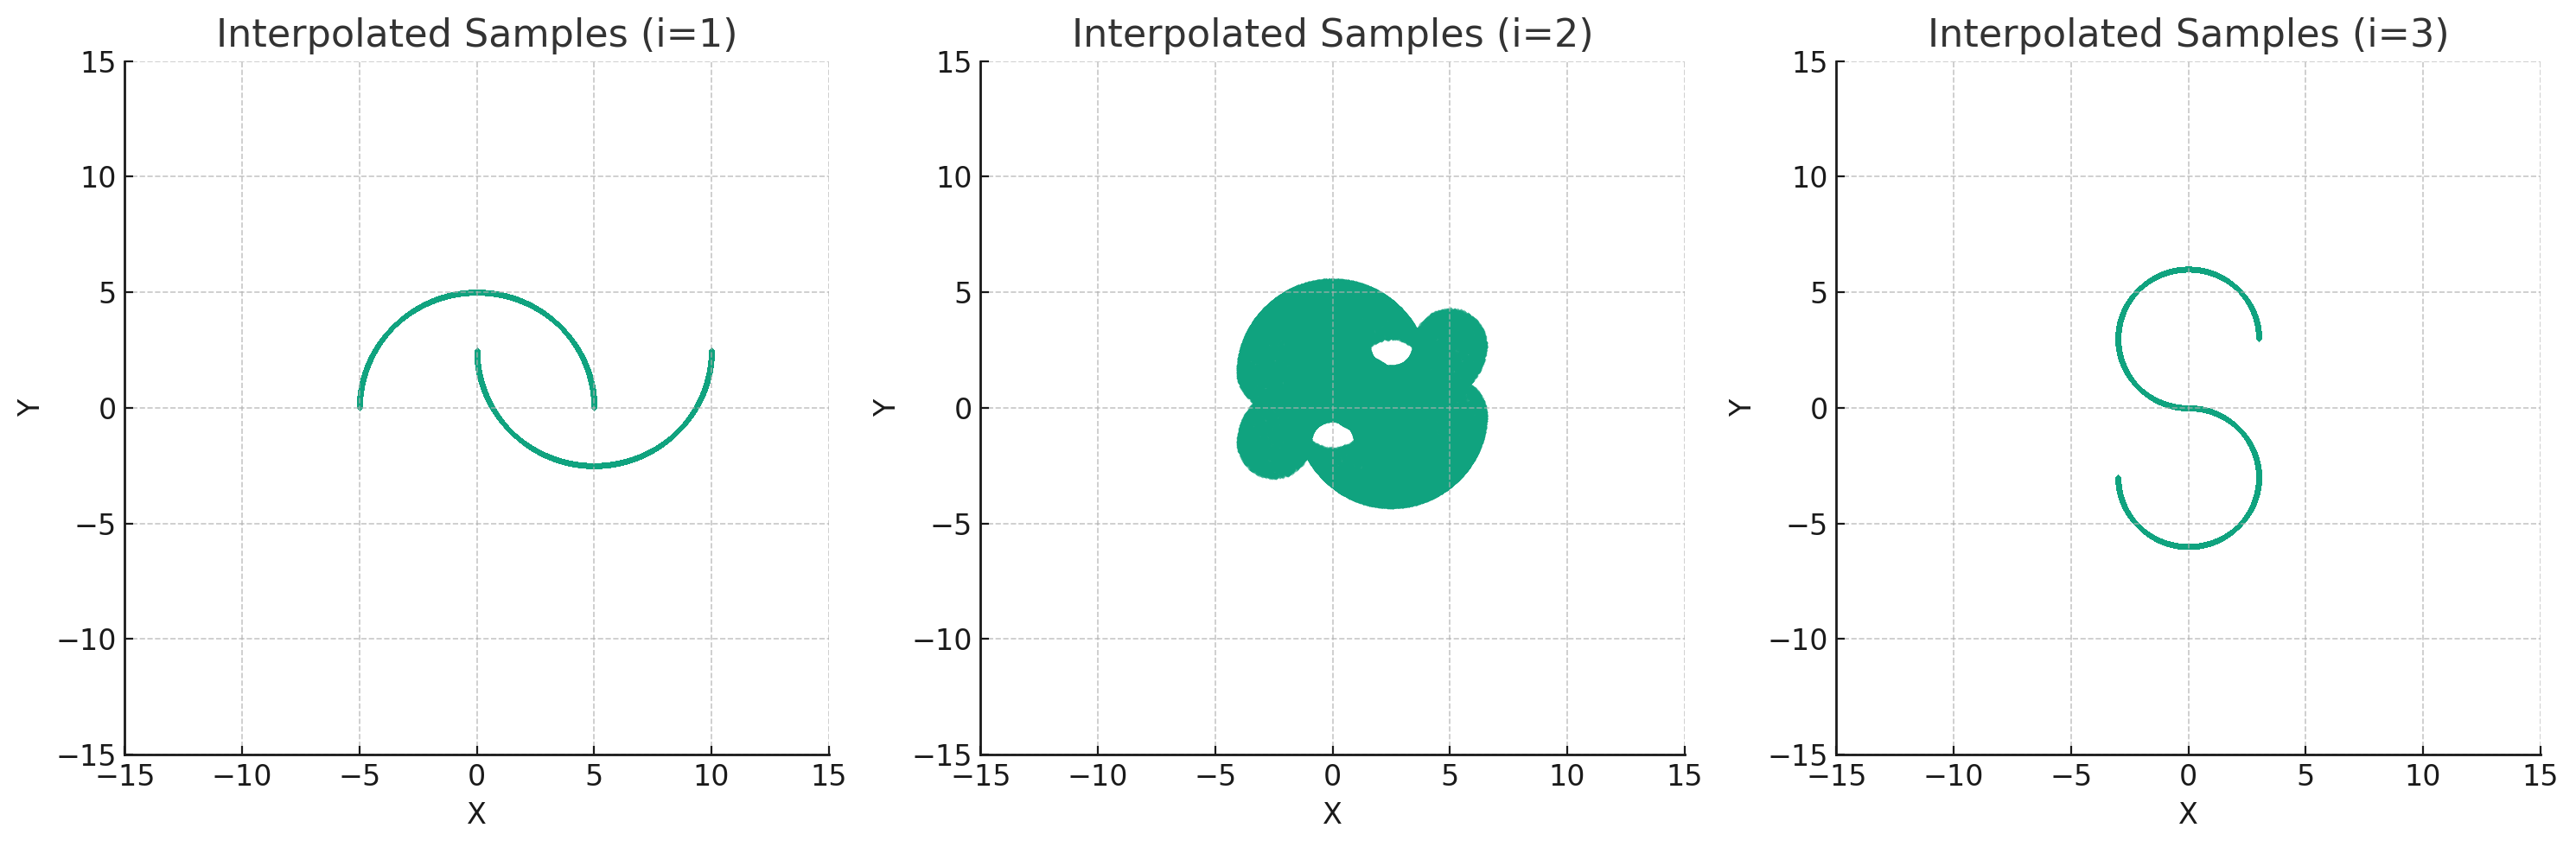

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_s_curve, make_swiss_roll, make_moons
from scipy.stats import multivariate_normal

# 生成高斯分布样本
def generate_gaussian_samples(mean, cov, n_samples)->np.ndarray:
    return multivariate_normal(mean, cov).rvs(n_samples)

# 生成S形曲线分布样本
def generate_swiss_roll_samples(n_samples, noise)->np.ndarray:
    s_curve_samples, _ = make_swiss_roll(n_samples, noise=noise,random_state=True, hole=False)
    # print(s_curve_samples.shape)
    return s_curve_samples[:, ::2]

def generate_moons_samples(n_samples, noise)->np.ndarray:
    s_curve_samples, _ = make_moons(n_samples, noise=noise,random_state=True)
    # print(s_curve_samples.shape)
    return s_curve_samples * 5

# 生成S形曲线分布样本
def generate_s_curve_samples(n_samples, noise)->np.ndarray:
    s_curve_samples, _ = make_s_curve(n_samples, noise=noise)
    # print(s_curve_samples.shape)
    return s_curve_samples[:, ::2] * 3

# 计算线性插值
def interpolate_samples(P1_samples, Pn_samples, i, n)->np.ndarray:
    alpha = (i - 1) / (n - 1)
    return alpha * Pn_samples + (1 - alpha) * P1_samples

# 设置参数
n_samples = 100000
mean = [0, 0]
cov = [[1, 0], [0, 1]]
noise = 0.
ti = 3

# 生成样本
P1_samples = generate_moons_samples(n_samples, noise)
Pn_samples = generate_s_curve_samples(n_samples, noise)


dists = []
fig,axs = plt.subplots(1, ti, figsize=(ti*5, 5))
for i in range(ti):
    interpolated_samples = interpolate_samples(P1_samples, Pn_samples, i+1, ti)
    dists.append(torch.Tensor(interpolated_samples))
    axs[i].scatter(interpolated_samples[:, 0], interpolated_samples[:, 1], alpha=0.5, s=1)
    axs[i].set_title(f'Interpolated Samples (i={i+1})')
    axs[i].set_xlabel('X')
    axs[i].set_ylabel('Y')
    axs[i].set_xlim(-15, 15)
    axs[i].set_ylim(-15, 15)
fig.tight_layout()
fig.show()

In [6]:
def wash_distance(a, b):
    assert len(a) == len(b)
    n = min(len(a) , 500)
    ind = torch.ones(n)/n    
    return ot.emd2(ind, ind, torch.Tensor(ot.dist(a[:n], b[:n])))


In [7]:
# 生成二维Brownian bridge
def gen_bridge_2d(x, y, ts, T, num_samples):
    sigma = SIGMA
    bridge = torch.zeros((ts.shape[0], num_samples, 2))
    drift = torch.zeros((ts.shape[0], num_samples, 2))
    bridge[0] = x
    for i in range(len(ts) - 1):
        dt = ts[i+1] - ts[i]
        dydt = (y - bridge[i]) / (T - ts[i])
        drift[i, :] = dydt
        diffusion = sigma * torch.sqrt(dt) * torch.randn(num_samples, 2)
        bridge[i+1] = bridge[i] + dydt * dt
        bridge[i+1, :] += diffusion
    return bridge, drift

def gen_2d_data(source_dist, target_dist, epsilon=0.001, T=1):
    ts = torch.arange(0, T+epsilon, epsilon)
    source_dist = torch.Tensor(source_dist)
    target_dist = torch.Tensor(target_dist)
    assert source_dist.shape == target_dist.shape
    num_samples = len(source_dist)
    bridge, drift = gen_bridge_2d(source_dist, target_dist, ts, T=T, num_samples=num_samples)
    return ts, bridge, drift

def draw_gaussian2d(bridge,ts, show_rate=1.):
    # 创建3D图形
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    draw_gaussian2d_base(fig, ax, bridge, ts, show_rate)
    return fig

def draw_gaussian2d_multi(bridges,ts, show_rate=1.):
    # 创建3D图形
    if show_rate < 1.:
        # generate random indices
        indices = np.random.choice(bridges[0].shape[1], int(bridges[0].shape[1]*show_rate), replace=False)
        
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ts_length = bridges[0].shape[0]-1
    color_list = ['r', 'g', 'b', 'y']
    for index, bridge in enumerate(bridges):
        draw_gaussian2d_base(fig, ax, bridge[:, indices, :], ts[index*ts_length:(index+1)*ts_length+1], show_rate=1, color=color_list[index%4])
    return fig

def draw_gaussian2d_base(fig, ax, bridge,ts, show_rate=1., color=None):
    if show_rate < 1.:
        # generate random indices
        indices = np.random.choice(bridge.shape[1], int(bridge.shape[1]*show_rate), replace=False)
        bridge = bridge[:, indices, :]
    
    ax.scatter(bridge[0, :, 0].numpy(), bridge[0, :, 1].numpy(), ts[0].numpy(), c='r' if color is None else color, label='Start', s=2, alpha=0.3)

    # # 为每个样本绘制bridge
    for i in range(bridge.shape[1]):
        x = bridge[:, i, 0].numpy()  # X坐标
        y = bridge[:, i, 1].numpy()  # Y坐标
        z = ts.numpy()               # 时间作为Z坐标
        ax.plot(x, y, z, 'gray', label=f'Sample {i+1}', alpha=0.1, linewidth=1)        
    
    ax.scatter(bridge[-1, :, 0].numpy(), bridge[-1, :, 1].numpy(), ts[-1].numpy(), c='g' if color is None else color, label='End', s=2, alpha=0.3)
    
    # 添加标签和图例
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Time')

    return fig, ax

In [8]:
def train(model, train_dl, optimizer, scheduler, loss_fn):
    losses = 0
    for training_data in train_dl:
        training_data = training_data.to(device)
        x, t, y = training_data[:, :-3], training_data[:, -3:-2] , training_data[:, -2:] # 不同模型要改

        pred = model(x, t)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        optimizer.zero_grad()
        losses += loss.item() / len(train_dl)
        
    return losses

In [9]:
from utils.basic import ScoreNetwork
model_list = []
for i in range(ti):
    if i < ti-1:
        src_dist = dists[i]
        tgt_dist = dists[i+1]
        ts, bridge, drift = gen_2d_data(src_dist, tgt_dist, epsilon=0.01, T=1/ti)
    else:
        src_dist = dists[0]
        tgt_dist = dists[-1]
        ts, bridge, drift = gen_2d_data(src_dist, tgt_dist, epsilon=0.01, T=1)
    # draw_gaussian2d(bridge,ts, show_rate=0.1)

    start = torch.cat(torch.split(src_dist.repeat(len(ts)-1, 1, 1), 1, dim=1), dim=0)
    times = ts[:len(ts)-1].repeat(n_samples, 1).reshape(-1, 1, 1)
    positions = torch.cat(torch.split(bridge[:-1, :], 1, dim=1), dim=0)

    scores = torch.cat(torch.split(drift[:-1, :], 1, dim=1), dim=0)
    raw_data = torch.concat([positions, times, scores], dim=-1)
    print(raw_data.shape)
    
    epochs = 100
    batch_size = 20000
    lr = 1e-3

    # 组合成data
    train_ds = BBdataset(raw_data[:,0])
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=24)
    # 3 128
    # model = MLP(input_dim=3, output_dim=2, hidden_layers=2, hidden_dim=256, act=nn.ReLU()).to(device)
    model = ScoreNetwork(encoder_layers=[64, 256], pos_dim=64, decoder_layers=[64, 256], x_dim=2).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=1e-6)
    loss_fn = nn.MSELoss()
    loss_list = []
    dummy_data = train_ds[0:3]
    if i==0:
        summary(model, input_data=[dummy_data[:, :-3], dummy_data[:, -3:-2]],verbose=1)
    
    epoch_iterator = tqdm(range(epochs), desc="Training (lr: X)  (loss= X)", dynamic_ncols=True)
    model.train()
    for e in epoch_iterator:
        now_loss = train(model ,train_dl, optimizer, scheduler, loss_fn)
        loss_list.append(now_loss)
        cur_lr = optimizer.param_groups[-1]['lr']
        epoch_iterator.set_description("Training (lr: %2.5f)  (loss=%2.5f)" % (cur_lr, now_loss))
    epoch_iterator.close()
    model_list.append(model)

torch.Size([3400000, 1, 5])
Layer (type:depth-idx)                   Output Shape              Param #
├─MLP: 1-1                               [-1, 128]                 --
|    └─ModuleList: 2                     []                        --
|    |    └─Linear: 3-1                  [-1, 64]                  4,160
|    └─GELU: 2-1                         [-1, 64]                  --
|    └─ModuleList: 2                     []                        --
|    |    └─Linear: 3-2                  [-1, 256]                 16,640
|    └─GELU: 2-2                         [-1, 256]                 --
|    └─ModuleList: 2                     []                        --
|    |    └─Linear: 3-3                  [-1, 128]                 32,896
├─MLP: 1-2                               [-1, 128]                 --
|    └─ModuleList: 2                     []                        --
|    |    └─Linear: 3-4                  [-1, 64]                  192
|    └─GELU: 2-3                         [-1,

Training (lr: X)  (loss= X):   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([3400000, 1, 5])


Training (lr: X)  (loss= X):   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000000, 1, 5])


Training (lr: X)  (loss= X):   0%|          | 0/100 [00:00<?, ?it/s]

In [10]:
def inference(model, test_ts, test_source_sample, test_num_samples):
    pred_bridge = torch.zeros(len(test_ts), test_num_samples, 2)
    pred_bridge[0, :] = test_source_sample
    model.eval()
    model.cpu()
      
    sigma = SIGMA
    with torch.no_grad():
        for i in range(len(test_ts) - 1):
            dt = (test_ts[i+1] - test_ts[i])

            test_ts_reshaped = test_ts[i].reshape(-1, 1, 1).repeat(test_num_samples, 1, 1)
            pred_bridge_reshaped = pred_bridge[i].reshape(-1, 1, pred_bridge.shape[-1])
            dydt = model(pred_bridge_reshaped,test_ts_reshaped)
            diffusion = sigma * torch.sqrt(dt) * torch.randn(test_num_samples, 2)
            dydt = dydt.squeeze()
            pred_bridge[i+1, :] = pred_bridge[i, :] + dydt * dt
            pred_bridge[i+1, :] += diffusion
            
    return pred_bridge

In [11]:
# save model_list for each model
for i, model in enumerate(model_list):
    torch.save(model, log_dir / f'model_{i}.pt')

In [12]:
# 生成样本
test_num_samples = 2000
test_P1_samples = generate_moons_samples(test_num_samples, noise)
test_Pn_samples = generate_s_curve_samples(test_num_samples, noise)
test_ts, test_bridge, test_drift = gen_2d_data(test_P1_samples, test_Pn_samples, epsilon=0.01, T=1)
temp_src = torch.Tensor(test_P1_samples)
test_pred_bridges = []
for i, model in enumerate(model_list[:-1]):
    test_pred_bridges.append(inference(model, test_ts[:len(test_ts)//(ti-1)+1], temp_src, test_num_samples))
    temp_src = test_pred_bridges[-1][-1, :, :].clone()
    
test_pred_bridge_one_step = inference(model_list[-1], test_ts, torch.Tensor(test_P1_samples), test_num_samples)

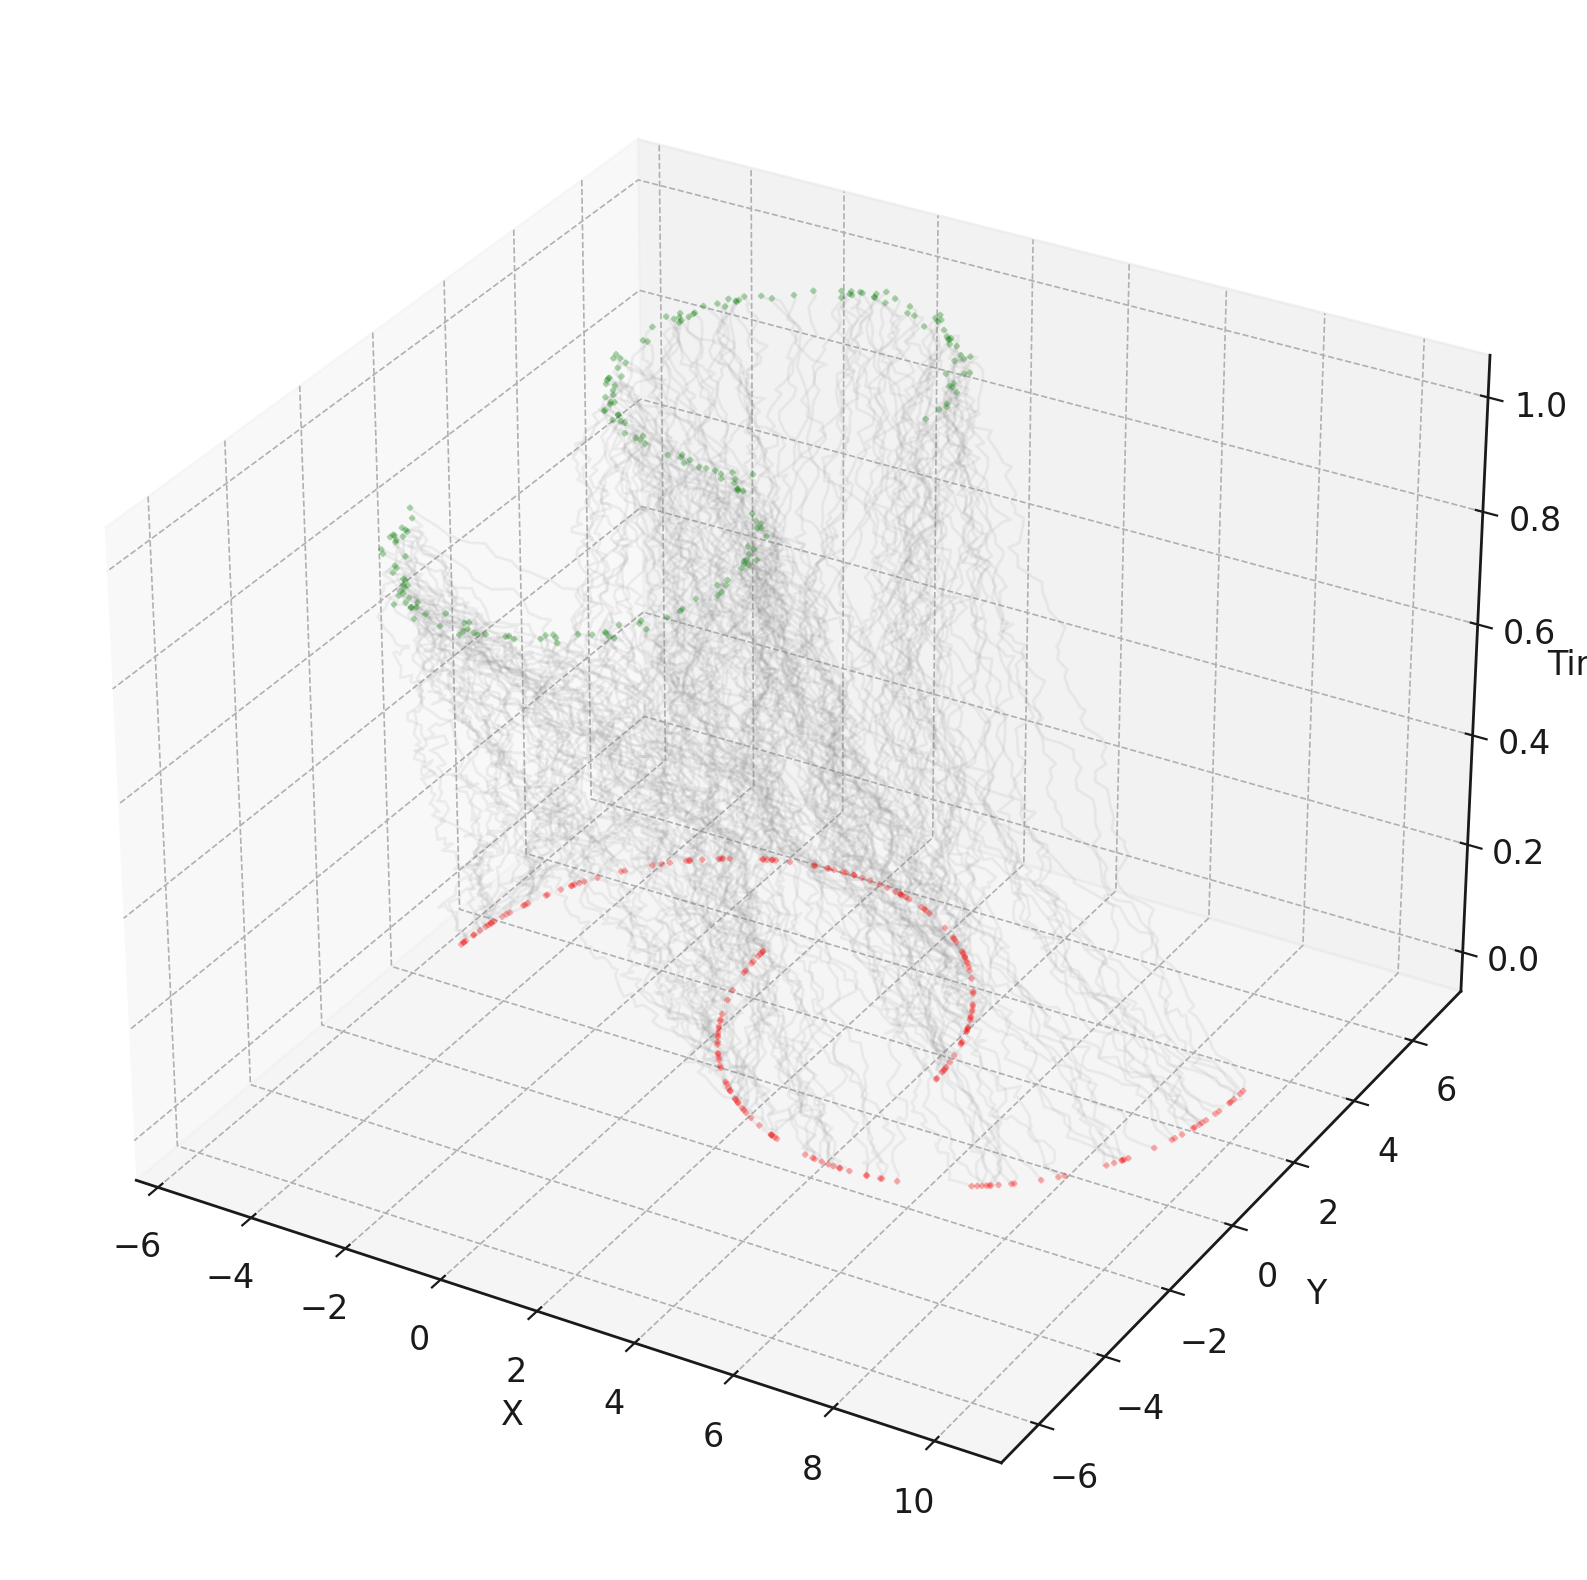

In [13]:
draw_gaussian2d(test_pred_bridge_one_step, test_ts, show_rate=0.1).show()

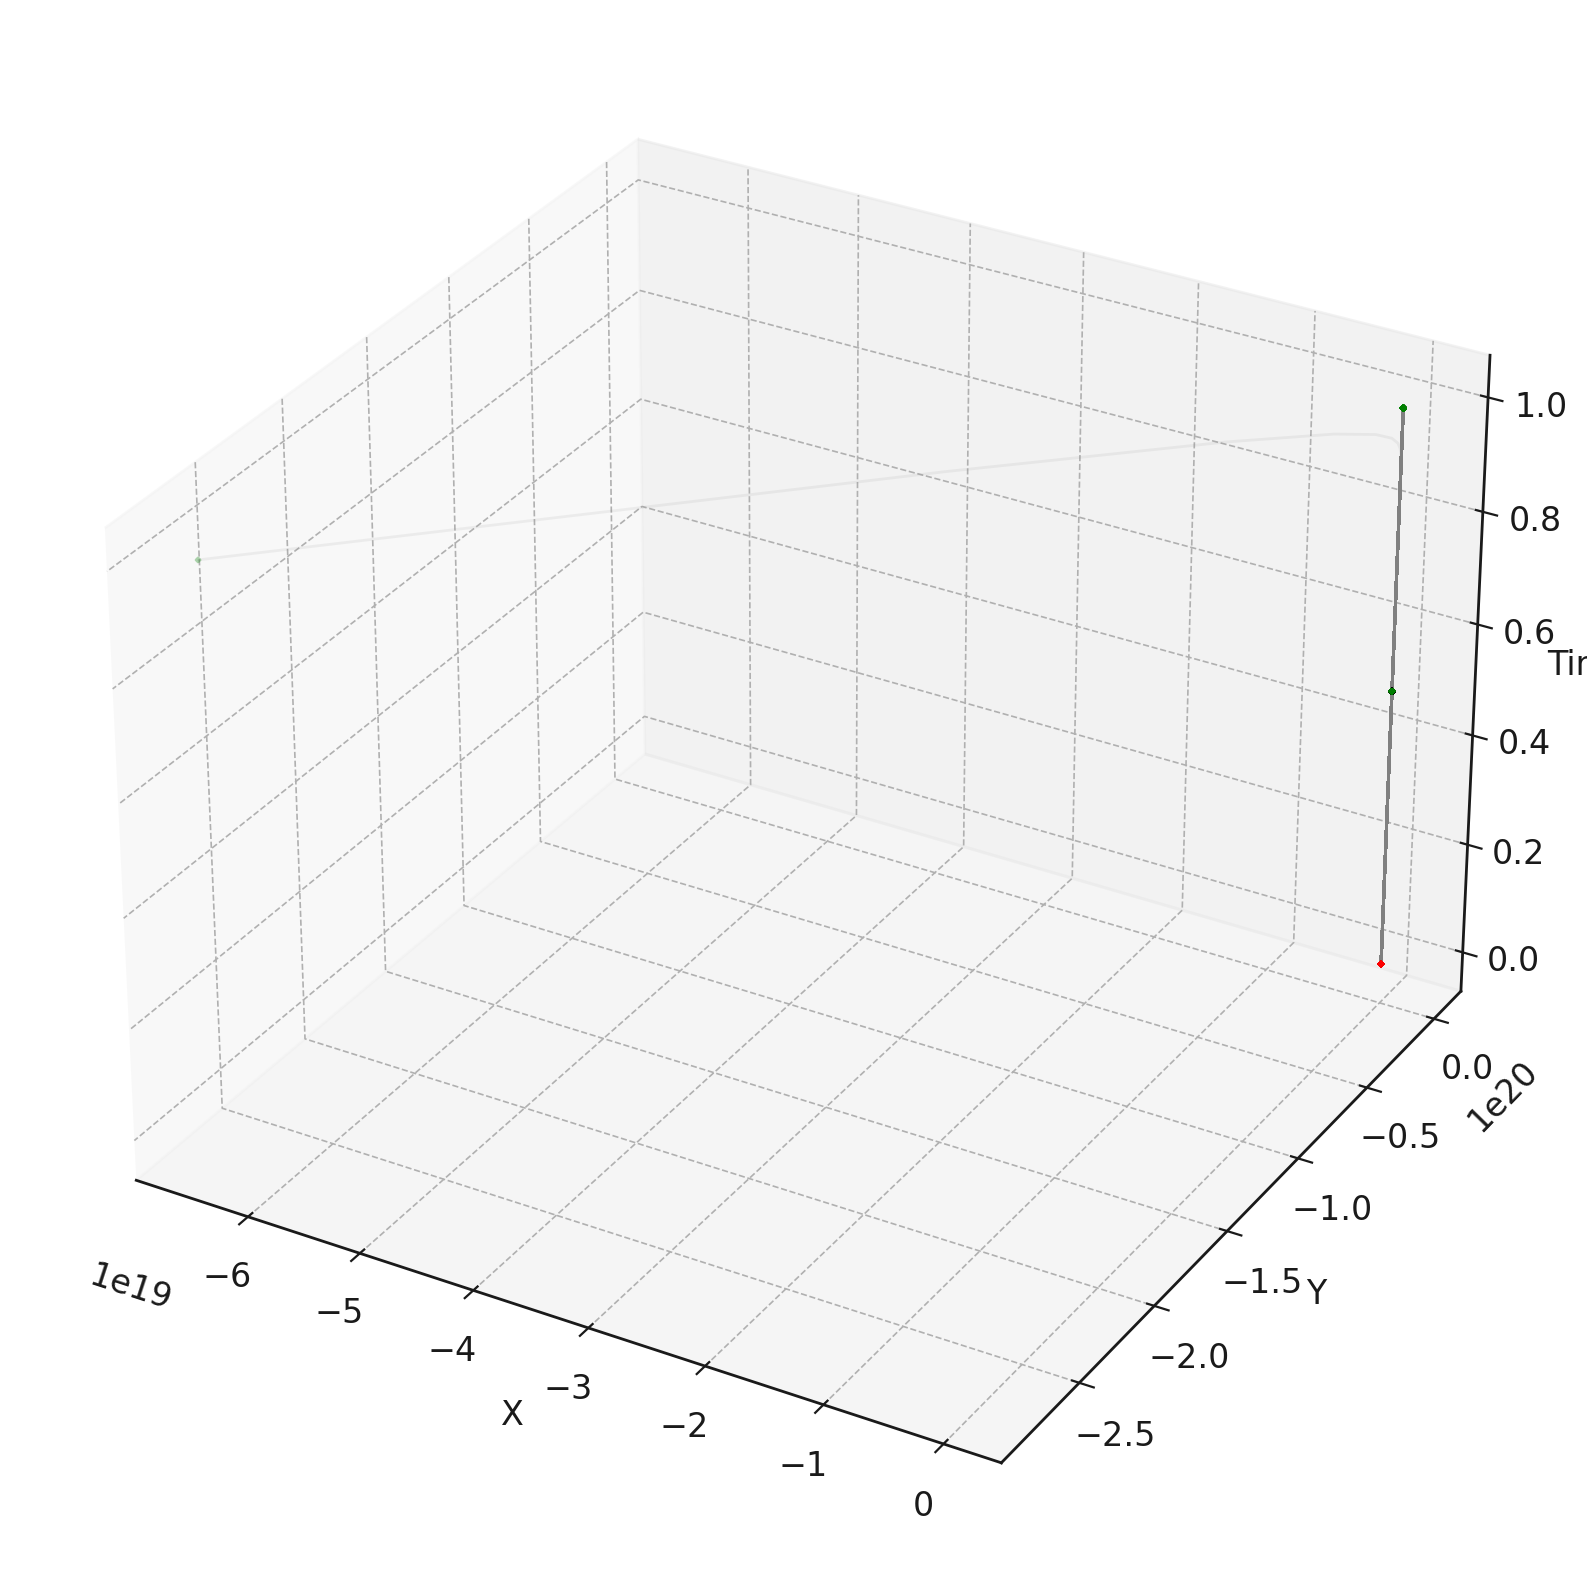

In [14]:
# for p_bridge in terst_pred_bridges:
#     draw_gaussian2d(p_bridge,ts, show_rate=0.1).show()
draw_gaussian2d_multi(test_pred_bridges, test_ts, show_rate=0.1).show()

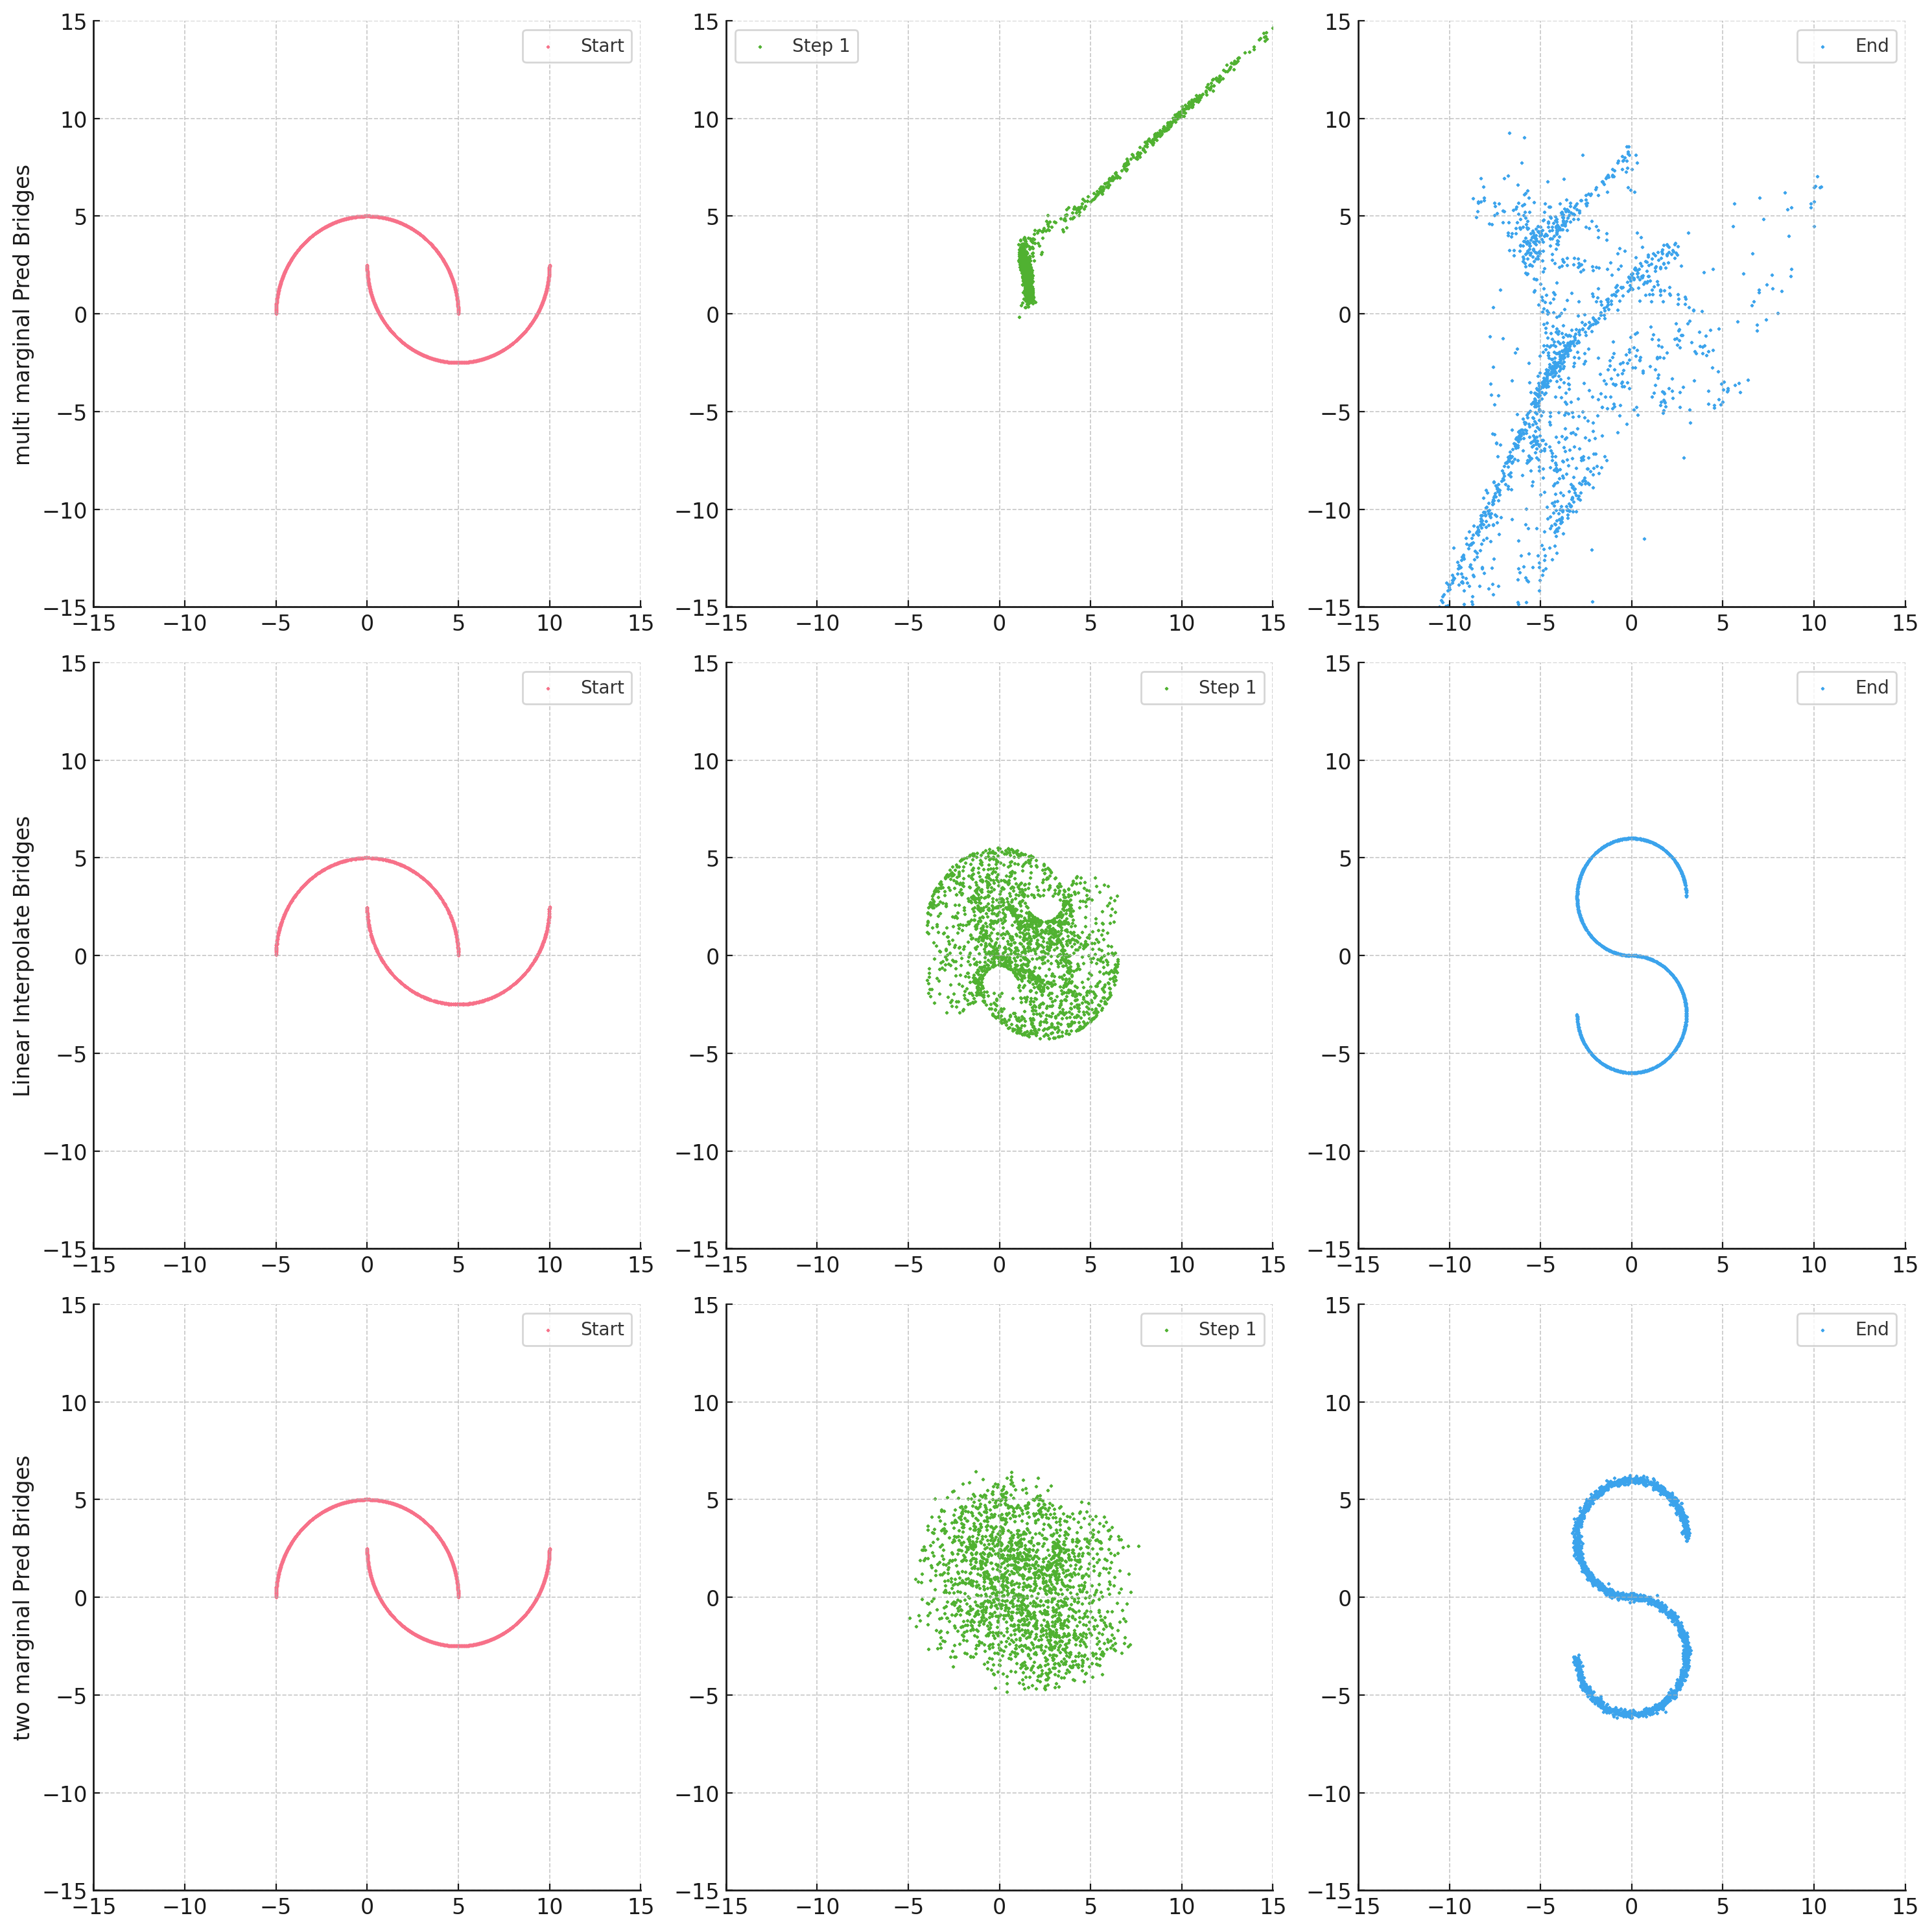

In [15]:
def draw_comapre(dists, test_pred_bridges, test_pred_bridge_one_step, bound=15):
    n_sub_interval = len(dists)
    fig, axs = plt.subplots(3, n_sub_interval, figsize=(5*n_sub_interval, 15))
    show_rate = min(len(dists[0]), 2000) / len(dists[0])

    labels = {}
    labels[0] = 'Start'
    labels[n_sub_interval-1] = 'End'
    for i in range(1, n_sub_interval-1):
        labels[i] = f'Step {i}'

    colors = sns.color_palette("husl", n_sub_interval)
    
    def plot_test_pred_bridges(sub_axs, data):
        for i in range(n_sub_interval):
            now = data[i][0, :] if i != n_sub_interval-1 else data[i-1][-1, :]
            sub_axs[i].scatter(*now.numpy().T, alpha=1, s=1, color=colors[i], label=labels[i])
            sub_axs[i].legend()
            sub_axs[i].set_xlim(-bound, bound)
            sub_axs[i].set_ylim(-bound, bound)
            
    plot_test_pred_bridges(axs[0], test_pred_bridges)
    axs[0][0].set_ylabel('multi marginal Pred Bridges')
    
    
    def plot_dists(sub_axs, data):
        indices = np.random.choice(dists[0].shape[0], int(dists[0].shape[0]*show_rate), replace=False)
        for i in range(n_sub_interval):
            now = data[i][indices]
            sub_axs[i].scatter(*now.numpy().T, alpha=1, s=1, color=colors[i], label=labels[i])
            sub_axs[i].legend()
            sub_axs[i].set_xlim(-bound, bound)
            sub_axs[i].set_ylim(-bound, bound)
            
    plot_dists(axs[1], dists)
    axs[1][0].set_ylabel('Linear Interpolate Bridges')
        
    def plot_test_pred_bridge_one_step(sub_axs, data):
        tis = len(test_pred_bridges[0])-1
        for i in range(n_sub_interval):
            now = data[tis*i]
            sub_axs[i].scatter(*now.numpy().T, alpha=1, s=1, color=colors[i], label=labels[i])
            sub_axs[i].legend()
            sub_axs[i].set_xlim(-bound, bound)
            sub_axs[i].set_ylim(-bound, bound)
    
    plot_test_pred_bridge_one_step(axs[2], test_pred_bridge_one_step)
    axs[2][0].set_ylabel('two marginal Pred Bridges')
    
    # tis = len(test_pred_bridges[0])-1
    # axs[2][0].scatter(*test_pred_bridge_one_step[0].numpy().T, alpha=0.5, s=1, c='r', label='Start')
    # axs[2][1].scatter(*test_pred_bridge_one_step[tis].numpy().T, alpha=0.5, s=1, c='g', label='Step 1')
    # axs[2][2].scatter(*test_pred_bridge_one_step[tis*2].numpy().T, alpha=0.5, s=1, c='b', label='Step 2')
    # axs[2][3].scatter(*test_pred_bridge_one_step[tis*3].numpy().T, alpha=0.5, s=1, c='y', label='End')
    
    # set tight layout
    fig.tight_layout()
    
    # fig
    fig.show()
    
    return fig
    
draw_comapre(dists, test_pred_bridges, test_pred_bridge_one_step).savefig(log_dir / 'compare.pdf')


In [16]:
import imageio
import shutil
from rich.progress import track

def save_gif_frame(bridge, save_path=None, name='brownian_bridge.gif', bound=10):
    assert save_path is not None, "save_path cannot be None"
    save_path = Path(save_path)
    bridge = bridge[:, :, :].numpy()  # 降低采样率

    temp_dir = save_path / 'temp'
    if temp_dir.exists():
        shutil.rmtree(temp_dir)
    temp_dir.mkdir(exist_ok=True)
    frame = 0
    
    color_map = -np.sqrt(bridge[0, :, 0]**2 + bridge[0, :, 1]**2)
    for i in track(range(bridge.shape[0]), description="Processing image"):
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.clear()
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_xlim(-bound, bound)
        ax.set_ylim(-bound, bound)
        x = bridge[i, :, 0]  # 注意：
        y = bridge[i, :, 1]  # 注意：
        
        ax.scatter(x, y, c=color_map, alpha=1, s=10)
        fig.savefig(save_path / 'temp' / f'{frame:03d}.png', dpi=100)
        frame += 1
        fig.show()
        plt.close('all')
    frames = []
    for i in range(bridge.shape[0]):
        frame_image = imageio.imread(save_path / 'temp' / f'{i:03d}.png')
        frames.append(frame_image)
    imageio.mimsave(save_path / name, frames, duration=0.2)
    if temp_dir.exists():
        shutil.rmtree(temp_dir)

In [17]:
# save_gif_frame(test_pred_bridge_one_step, log_dir, name="pred_ring2s_one_step.gif", bound=15)
# save_gif_frame(torch.concat(test_pred_bridges, dim=0), log_dir, name="pred_ring2s.gif", bound=15)
# save_gif_frame(test_bridge, log_dir, name="linear_ring2s.gif", bound=15)